Examine Calibration of Runs Scored Model

    - In the last couple of notebooks, we built a model to predict the distribution of runs scored, given a hitting team and a pitching team

    - We then used an independence assumption to predict the probability that the number of runs scored was over, under, or equal to the Over/Under "line" for that game.

    - We were able to build a model that looked like it could profitably bet against the Las Vegas odds!

    - However, these final predictions were clearly not well-calibrated.

    - For example, there were 362 games where we expected to be right more than 70% of the time (ignoring pushes), but we were actually right only 56.7% of the time (ignoring pushes) (194/(194+148))

    - There are two possible sources for this error (could be either or both)

        -- The runs scored model is poorly calibrated

        -- The independence assumption is flawed in practice

    - In this notebook, we will explore the calibration of the runs scored model and scope possible solutions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
.7*(194+148)

239.39999999999998

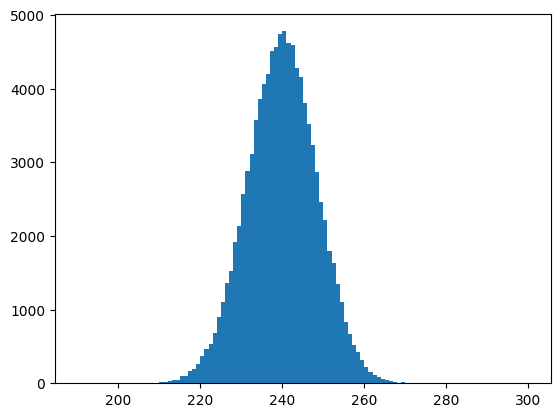

In [3]:
# How unlikely is it that we would get 194 (or fewer) successes in 342 trials if the success probability is .7?

plt.hist(np.random.binomial(n=(194+148), p=.7, size=100000), bins=np.linspace(190,300,111));

In [4]:
df = pd.read_csv('df_bp9.csv', low_memory=False)

df_runs = pd.read_csv('df_runs_bp11.csv', low_memory=False)

In [5]:
df.over_under_line.max()

15.0

In [6]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

In [7]:
df_train = df_runs[(df_runs.season>1970) & (df_runs.season<=2017) & ~(df_runs.OBP_162.isnull())]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]

BEGIN MODELING

    - Let's rebuild the same model as before

In [8]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']

In [9]:
bpv2 = np.linspace(-.5,16.5,18)
bpv2

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [10]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [11]:
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.449341291823702
i=10, eval_set_loss = 2.446687603138016
i=20, eval_set_loss = 2.444644556467337
i=30, eval_set_loss = 2.443014224555934
i=40, eval_set_loss = 2.4418218041231032
i=50, eval_set_loss = 2.4410017333440717
i=60, eval_set_loss = 2.44025985177519
i=70, eval_set_loss = 2.4396298387636093
i=80, eval_set_loss = 2.439197444944906
i=90, eval_set_loss = 2.438852928084458
i=100, eval_set_loss = 2.4384689610803187
i=110, eval_set_loss = 2.438239208463153
i=120, eval_set_loss = 2.438052775221025
i=130, eval_set_loss = 2.4379385106659104
i=140, eval_set_loss = 2.437796241796621
i=150, eval_set_loss = 2.4376485227169806
i=160, eval_set_loss = 2.437550218381234
i=170, eval_set_loss = 2.4374912606106736
i=180, eval_set_loss = 2.4375260803421988
i=190, eval_set_loss = 2.4375770671376396
i=200, eval_set_loss = 2.4376198064684678
i=210, eval_set_loss = 2.4376014399118477
i=220, eval_set_loss = 2.437623610565368
Stopping early: low pt was 5 steps ago


In [12]:
preds_test = cr1.predict_distributions(X_test)

In [13]:
preds_test.log_loss(y_test)

2.4495026317897546

Examine Calibration of Runs Scored model

    - Want to know how well calibrated our runs scored model is.

    - For example, when it predicts exactly 1 run scored with probability .15, does it really happen 15% of the time?

    - This is a bit complicated, as we effectively have a 17-class model

    - We will examine the calibration in two ways:

        1. Consider each multi-class prediction as 17 different predictions (exactly one of which will be correct in each row). Looking at a reliability diagram in this context can tell us, e.g., if we are systematically under or over-predicting rare events.

        2. Consider each of the 17-values as a binary classification problem. This well tell us if we are under/over-predicting shutouts or high runs scored values.

For approach 1, there is a slight issue that we do not have independence between the different observations in each row. So, we will randomly sample a column from each row to preserve independence

In [14]:
# make a "one-hot" encoded version of y_test

y_test_oh = np.zeros((len(y_test), 17))
for i,val in enumerate(y_test):
    y_test_oh[i,val]=1
y_test[:3], y_test_oh[:3,:]

(array([7, 4, 5]),
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]]))

In [15]:
pred_probs_test = preds_test.probmat
pred_probs_test[:3,:]

array([[0.05219017, 0.09957456, 0.12939769, 0.14272349, 0.13389171,
        0.11717653, 0.09381787, 0.0703459 , 0.050462  , 0.03548574,
        0.02620541, 0.01780952, 0.01228464, 0.00730088, 0.00459754,
        0.00263626, 0.0041001 ],
       [0.04221179, 0.08072166, 0.10815581, 0.13003257, 0.1324935 ,
        0.12130643, 0.10547344, 0.07996413, 0.05954608, 0.04391182,
        0.03273411, 0.02225567, 0.01556041, 0.00975621, 0.00613246,
        0.00370528, 0.00603862],
       [0.0704962 , 0.11965032, 0.14905526, 0.15136125, 0.13230865,
        0.10924061, 0.08313486, 0.06091414, 0.04305778, 0.02790759,
        0.01948089, 0.01241466, 0.00871949, 0.00497759, 0.00313996,
        0.00171941, 0.00242132]])

In [16]:
np.random.seed(0)
ind_to_use = np.random.randint(low=0, high=17, size=len(y_test))
y_test_oh_sampled = np.array([y_test_oh[i,ind_to_use[i]] for i in range(len(y_test))]).astype(int)
probs_test_sampled= np.array([pred_probs_test[i,ind_to_use[i]] for i in range(len(y_test))])
ind_to_use[:3], probs_test_sampled[:3], y_test_oh_sampled[:3]

(array([12, 15,  0]),
 array([0.01228464, 0.00370528, 0.0704962 ]),
 array([0, 0, 0]))

(0.0, 0.22)

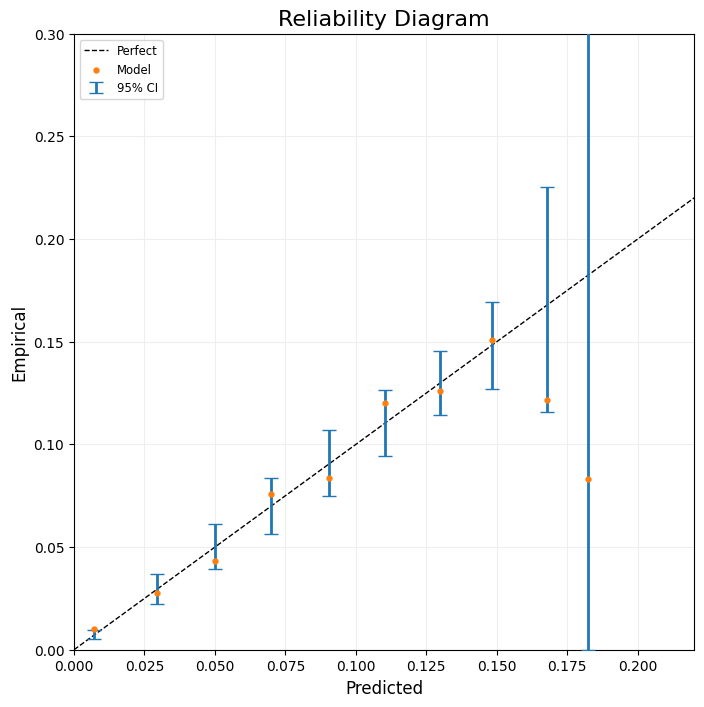

In [17]:
plt.figure(figsize=(8,8))
asd = mli.plot_reliability_diagram(y_test_oh_sampled, probs_test_sampled, np.linspace(0,1,51))
plt.ylim([0,.3])
plt.xlim([0,.22])

(0.0, 0.08)

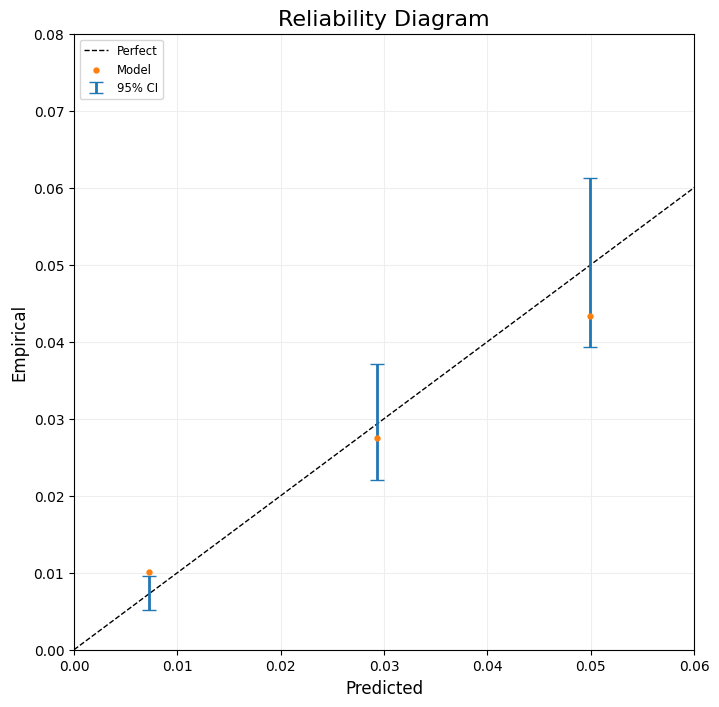

In [18]:
# Let's zoom in on the lower left part of the graph
plt.figure(figsize=(8,8))
asd = mli.plot_reliability_diagram(y_test_oh_sampled, probs_test_sampled, np.linspace(0,1,51))
plt.xlim([0,.06])
plt.ylim([0,.08])

(0.1, 0.25)

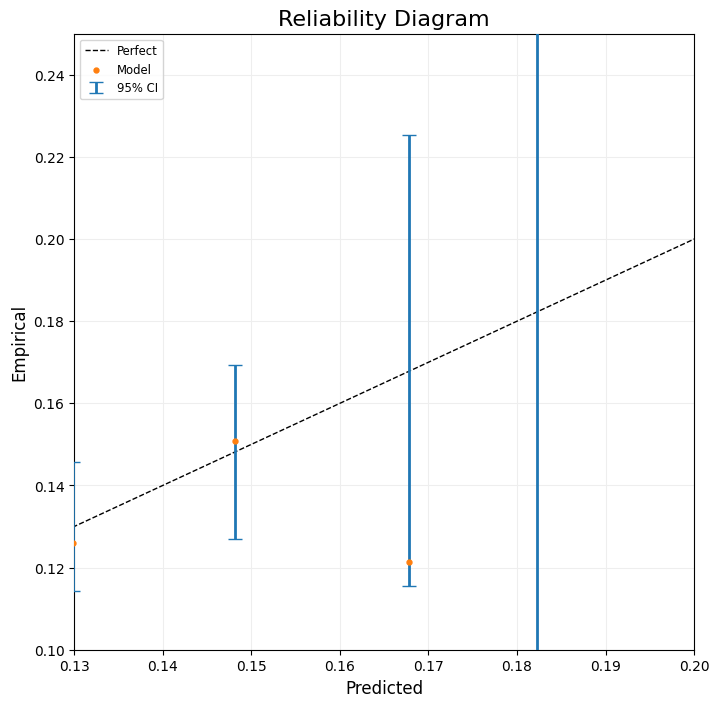

In [19]:
# Let's zoom in on the right half of the graph
plt.figure(figsize=(8,8))
asd = mli.plot_reliability_diagram(y_test_oh_sampled, probs_test_sampled, np.linspace(0,1,51))
plt.xlim([.13,.20])
plt.ylim([.10,.25])

Possibly we are over-predicting the probability around .17, but doesn't seem too severe. Changing the random seed doesn't show any consistent pattern...

Next, let's look at the problem from the point of view of 17 binary classifiers and see if we notice anything unusual

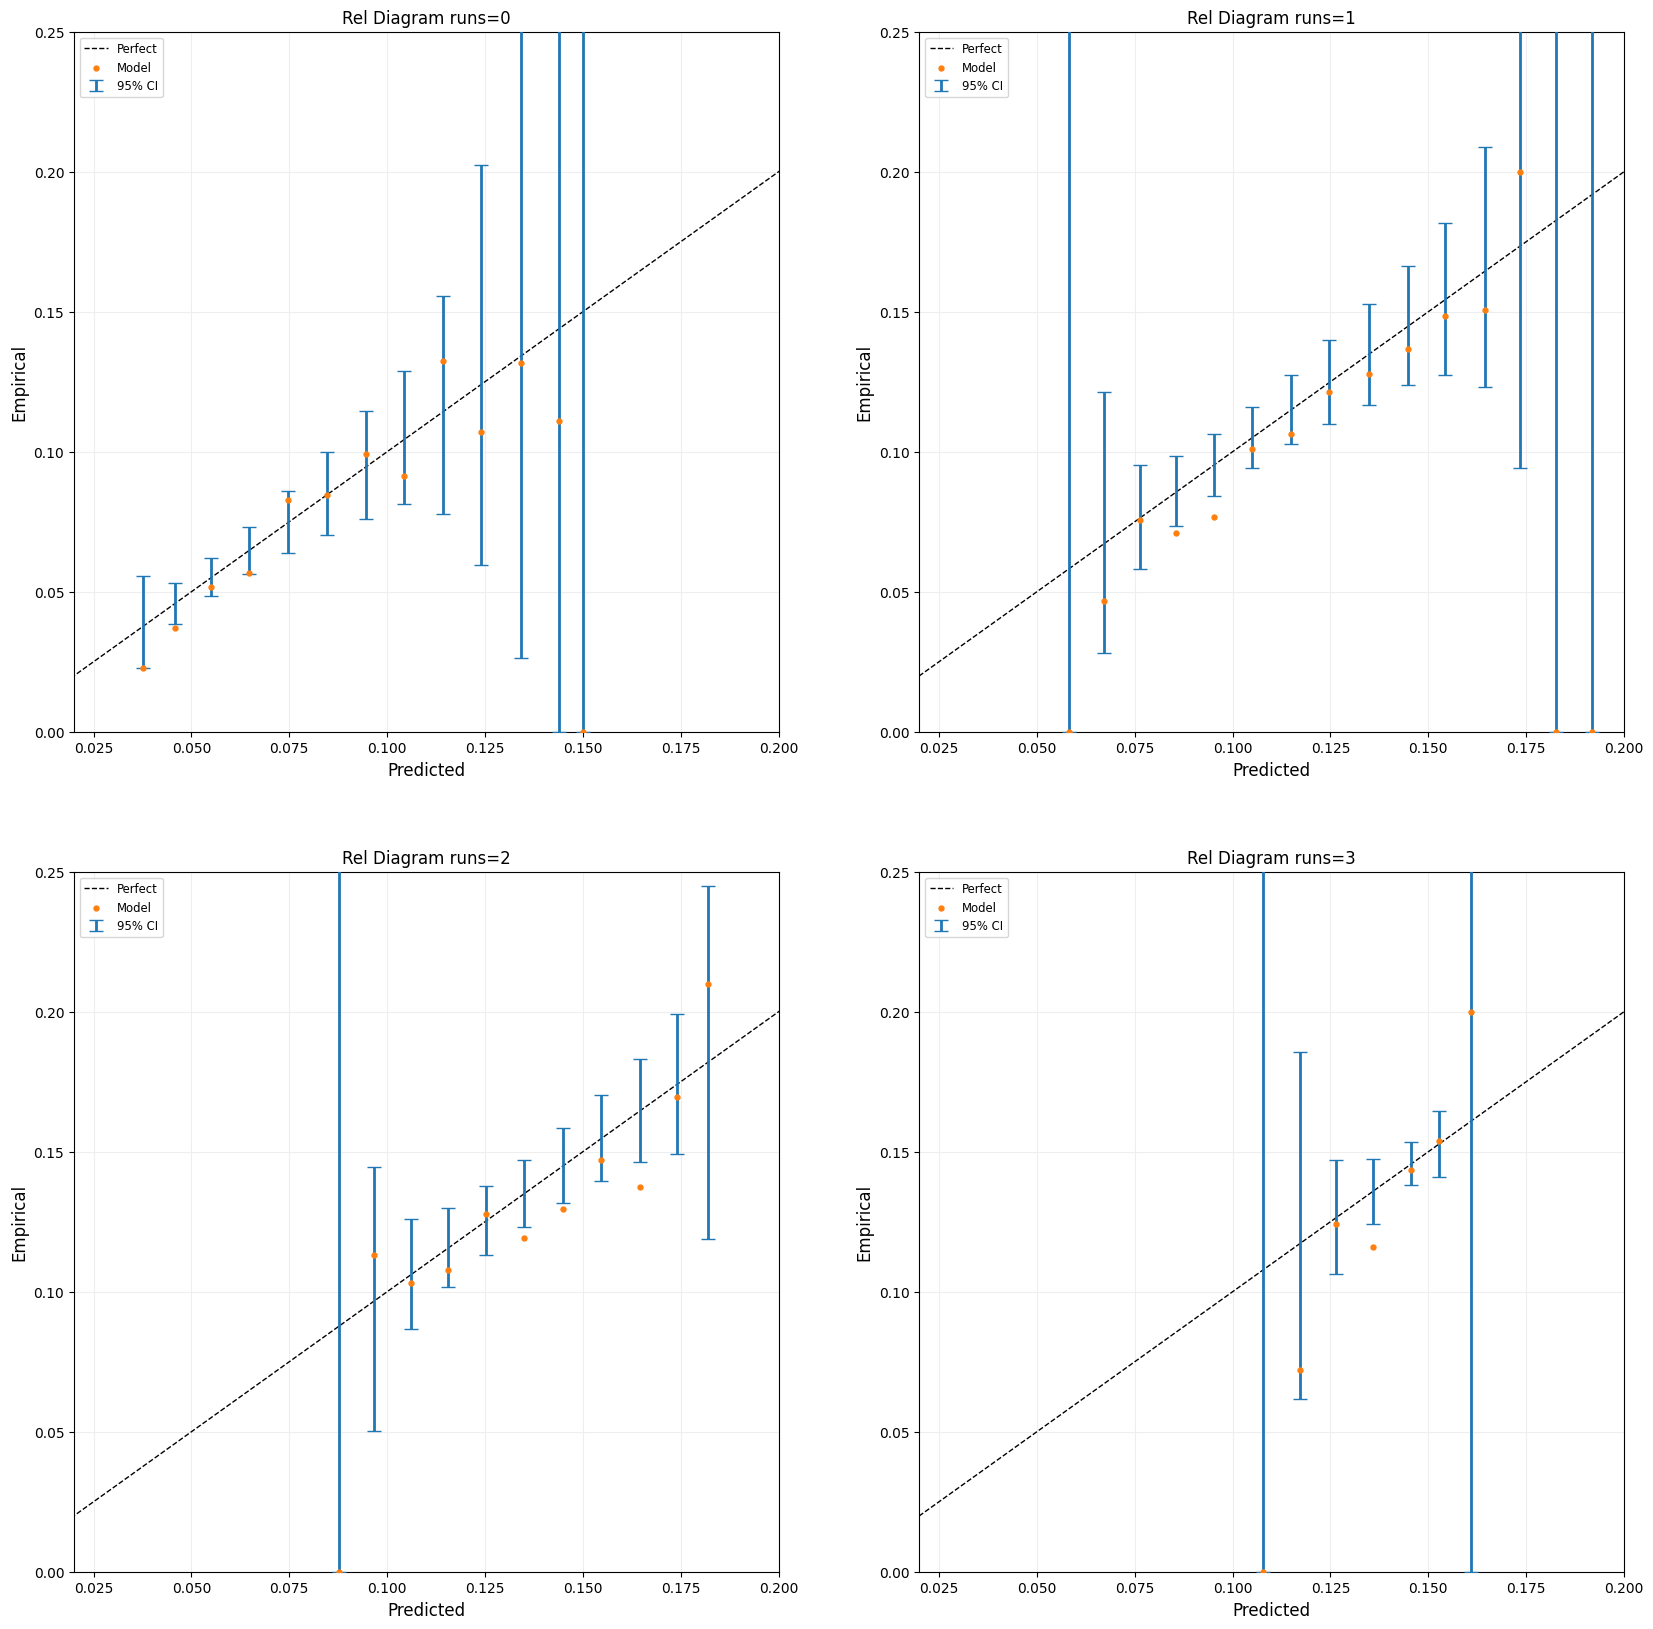

In [20]:
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(2,2,i+1)
    mli.plot_reliability_diagram((y_test==i).astype(int), preds_test.probmat[:,i], 
                                   np.linspace(0,1,101))
    plt.title(f'Rel Diagram runs={i}')
    plt.xlim([.02,.20])
    plt.ylim([0,.25])

Some suggestion that we are over-predicting the probability of low-scoring games

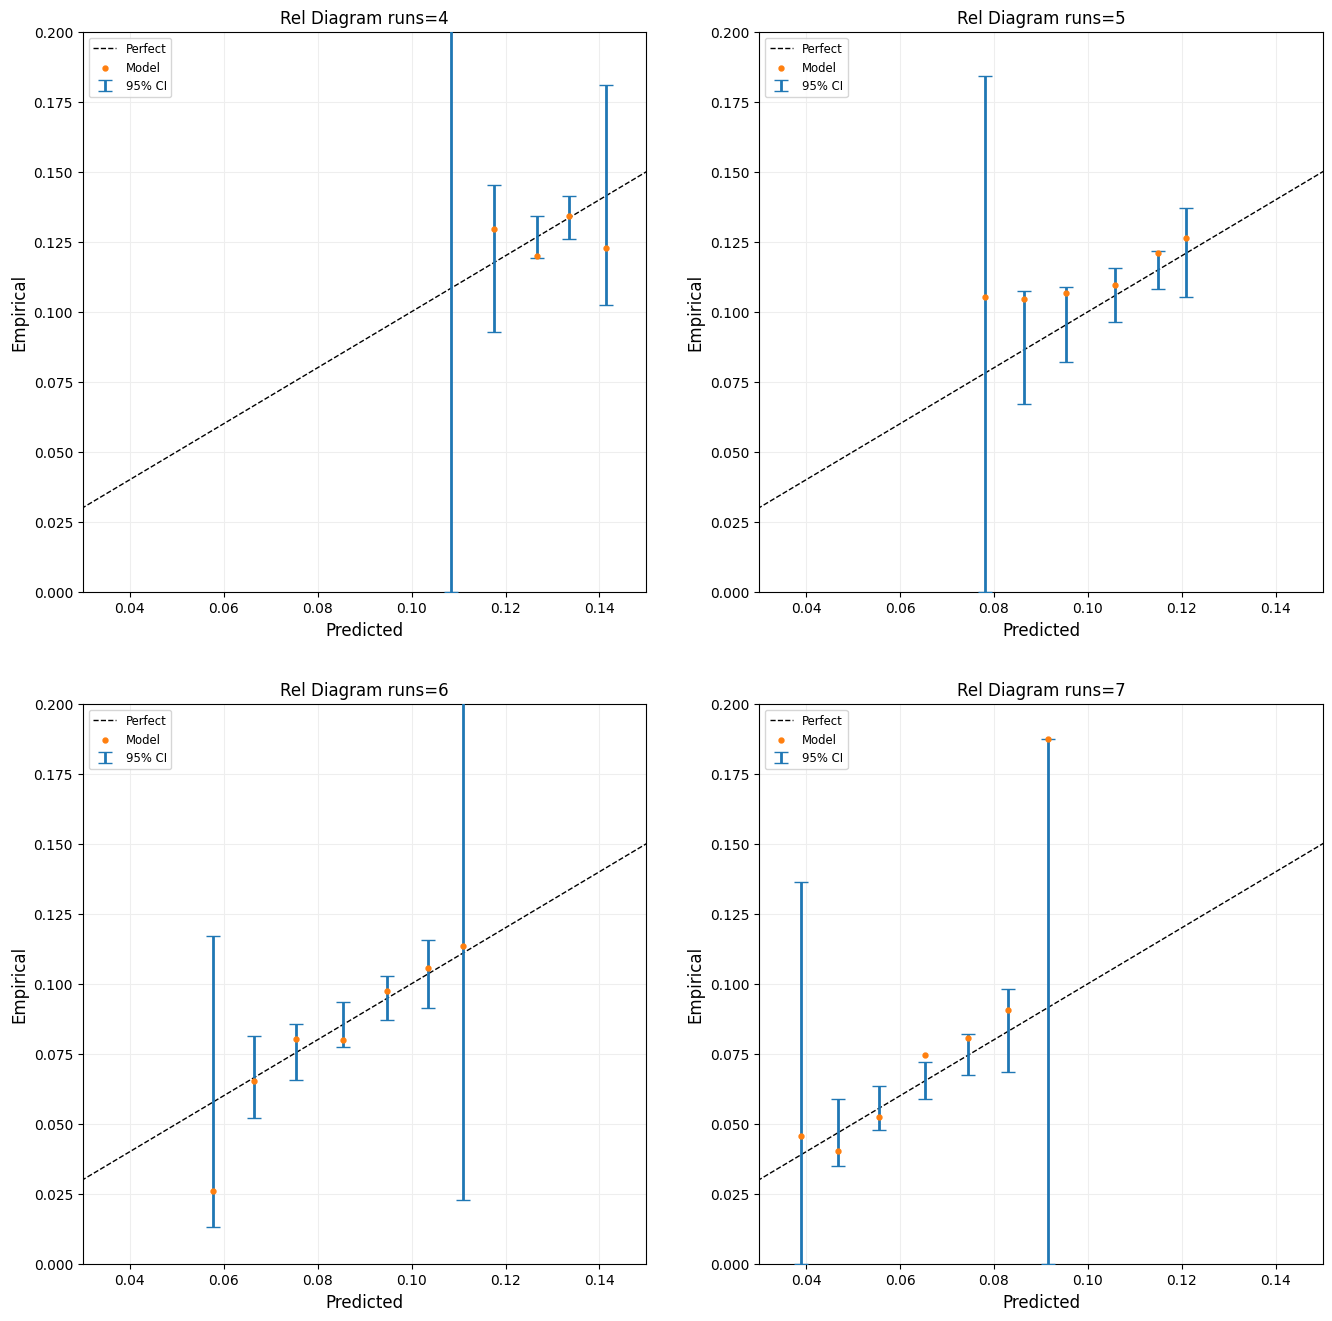

In [21]:
plt.figure(figsize=(16,16))
for i in range(4,8):
    plt.subplot(2,2,i-4+1)
    mli.plot_reliability_diagram((y_test==i).astype(int), preds_test.probmat[:,i], 
                                   np.linspace(0,1,101))
    plt.title(f'Rel Diagram runs={i}')
    plt.xlim([.03,.15])
    plt.ylim([0,.2])

ValueError: 'yerr' must not contain negative values

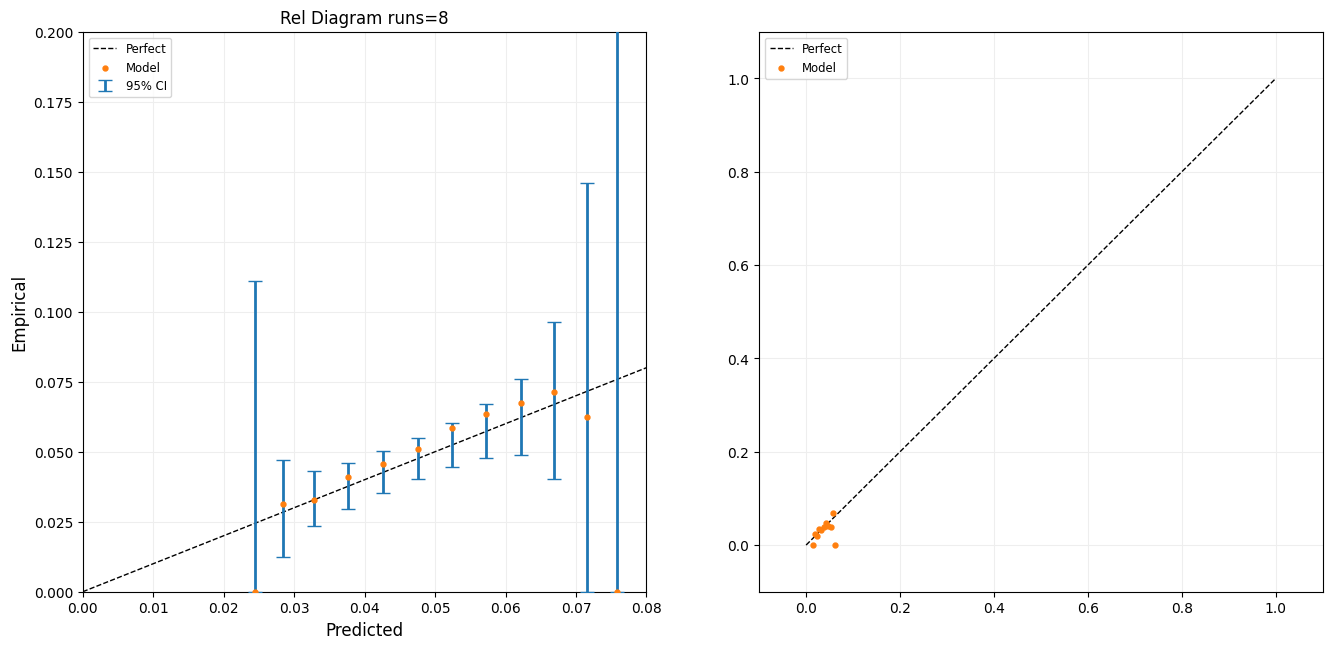

In [22]:
plt.figure(figsize=(16,16))
for i in range(8,12):
    plt.subplot(2,2,i-8+1)
    mli.plot_reliability_diagram((y_test==i).astype(int), preds_test.probmat[:,i], 
                                   np.linspace(0,1,201))
    plt.title(f'Rel Diagram runs={i}')
    plt.xlim([0,.08])
    plt.ylim([0,.2])

ValueError: 'yerr' must not contain negative values

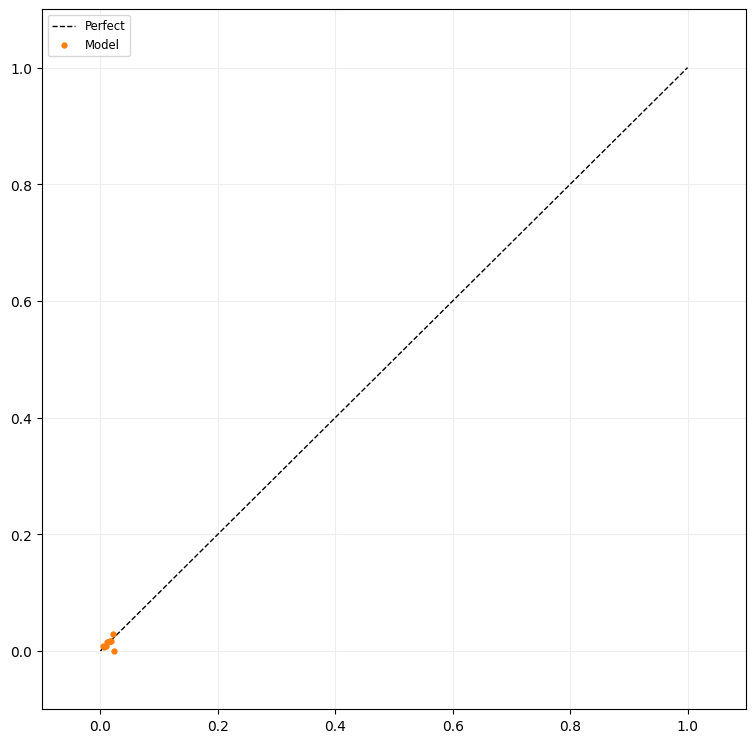

In [23]:
plt.figure(figsize=(20,20))
for i in range(12,16):
    plt.subplot(2,2,i-12+1)
    mli.plot_reliability_diagram((y_test==i).astype(int), preds_test.probmat[:,i], 
                                   np.linspace(0,1,401))
    plt.title(f'Rel Diagram runs={i}')
    plt.xlim([0,.02])
    plt.ylim([0,.05])

(0.0, 0.02)

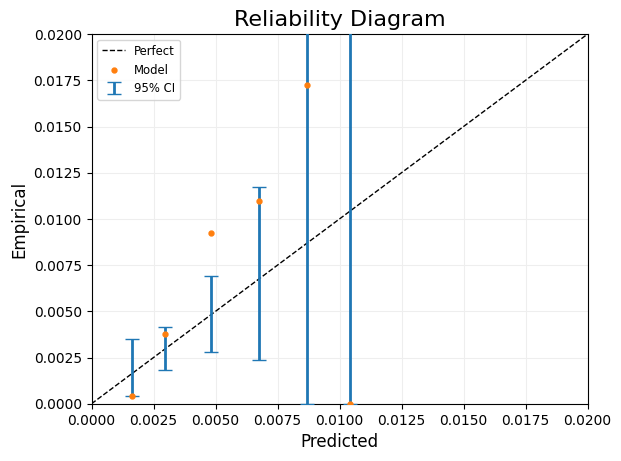

In [23]:
i=16
mli.plot_reliability_diagram((y_test==i).astype(int), preds_test.probmat[:,i], 
                               np.linspace(0,1,501))
plt.xlim([0,.02])
plt.ylim([0,.02])

Conversely, some evidence that we are underpredicting the probability of high team scores

In [24]:
mean_pred_probs = np.mean(preds_test.probmat, axis=0)
mean_pred_probs

array([0.06519575, 0.11168356, 0.13847542, 0.14382091, 0.12979104,
       0.10977656, 0.08817581, 0.06630131, 0.04758595, 0.03311639,
       0.02350525, 0.01548109, 0.01058924, 0.00643171, 0.00396091,
       0.00245608, 0.00365304])

In [25]:
mean_empirical_probs = np.mean(y_test_oh, axis=0)
mean_empirical_probs

array([0.06162123, 0.10264091, 0.12868321, 0.13864776, 0.12703264,
       0.11645678, 0.08839711, 0.07097445, 0.05159555, 0.03490647,
       0.02683702, 0.01815625, 0.01137058, 0.00843624, 0.00586869,
       0.00287321, 0.0055019 ])

In [26]:
mean_pred_probs/mean_empirical_probs

array([1.05800794, 1.08809986, 1.07609543, 1.03731147, 1.02171406,
       0.9426378 , 0.99749643, 0.93415744, 0.92228783, 0.94871778,
       0.87585169, 0.85265908, 0.9312842 , 0.76239015, 0.67492236,
       0.85481915, 0.66396034])

Some suggestion that we are overpredicting lower numbers of runs scored and underpredicting the high values. Recall that we were betting the over much more than the under...

Could be several reasons for this. Most likely possibility is "model drift" - the "data generation mechanism" was different in the test region than in the training region.

Let's make a reliability diagram of the "full" one-hot matrix (ignoring the lack of independence issue).

In [27]:
probs_test_flat = preds_test.probmat.copy().reshape(-1)
y_test_flat = y_test_oh.reshape(-1)

(0.0, 0.22)

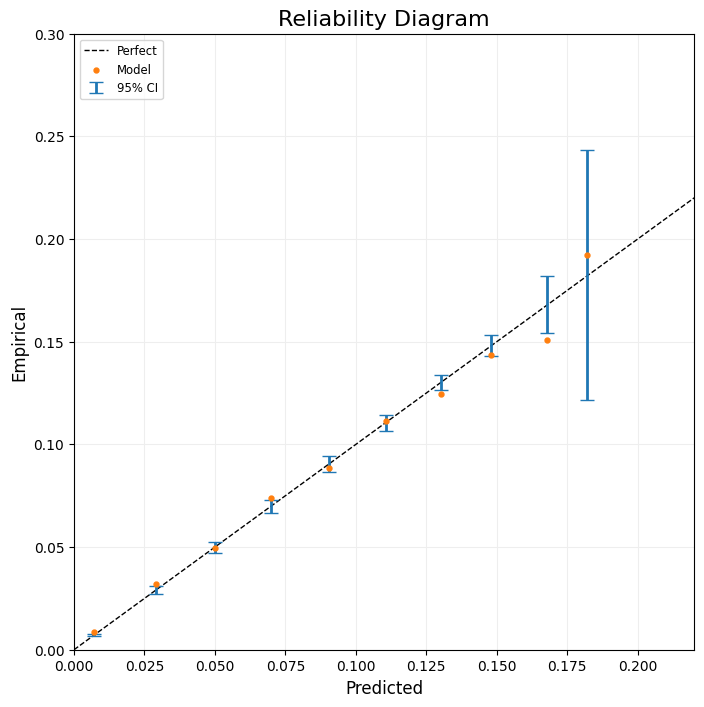

In [28]:
plt.figure(figsize=(8,8))
mli.plot_reliability_diagram(y_test_flat, probs_test_flat, np.linspace(0,1,51))
plt.ylim([0,.3])
plt.xlim([0,.22])

(0.0, 0.08)

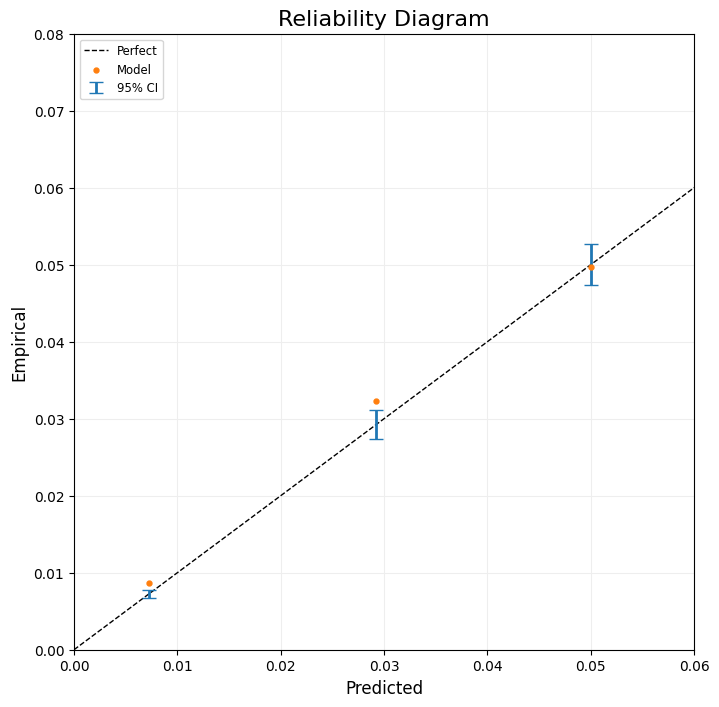

In [29]:
# Let's zoom in on the lower left part of the graph
plt.figure(figsize=(8,8))
asd = mli.plot_reliability_diagram(y_test_flat, probs_test_flat, np.linspace(0,1,51))
plt.xlim([0,.06])
plt.ylim([0,.08])

(0.1, 0.25)

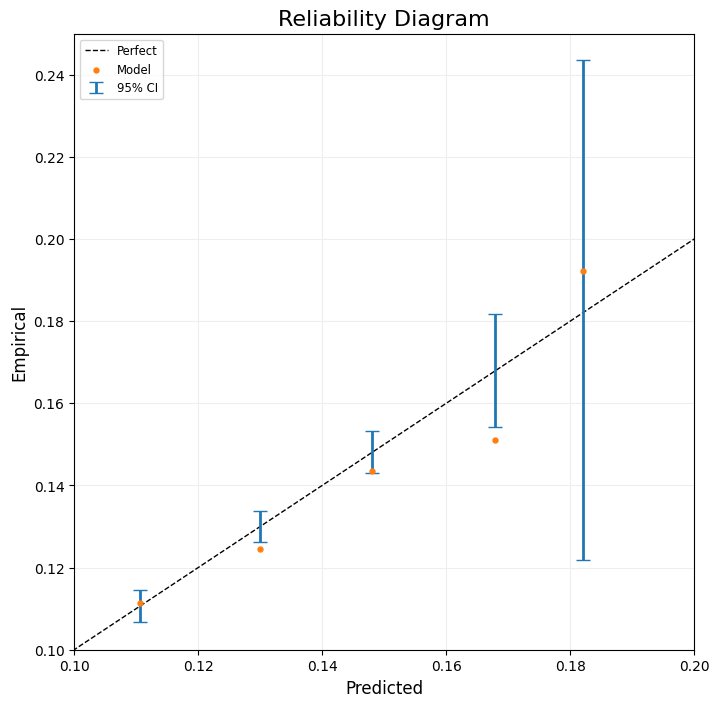

In [30]:
# Let's zoom in on the right half of the graph
plt.figure(figsize=(8,8))
asd = mli.plot_reliability_diagram(y_test_flat, probs_test_flat, np.linspace(0,1,51))
plt.xlim([.10,.20])
plt.ylim([.10,.25])

Forgetting the non-independence issue for now, looks like we are underpredicting the low probabilities (which correspond to high scores) and over-predicting the high probabilities (corresponding to low scores).

However, the magnitude of these errors does not seem to account for the poor calibration of the overall over/under model.

In [31]:
np.sum(mean_pred_probs[10:]), np.sum(mean_empirical_probs[10:])

(0.06607732092907422, 0.0790438928964421)

In [32]:
np.sum(mean_pred_probs[:5]), np.sum(mean_empirical_probs[:5])

(0.5889666685412945, 0.5586257488690549)

In [33]:
df_runs['runs_le4'] =  (df_runs.runs<=4).astype(int)
df_runs['runs_ge10'] = (df_runs.runs>=10).astype(int)

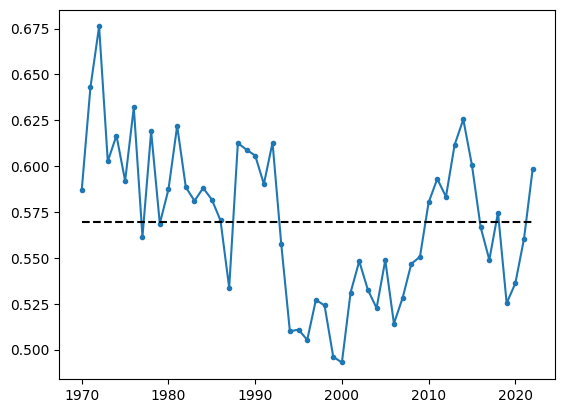

In [34]:
low_runs_by_season = df_runs.groupby('season').runs_le4.mean()
plt.plot(low_runs_by_season, marker='.')
plt.hlines(xmin=1970, xmax=2022, y=df_runs[df_runs.season<=2017].runs_le4.mean(), linestyle='--', color='k')

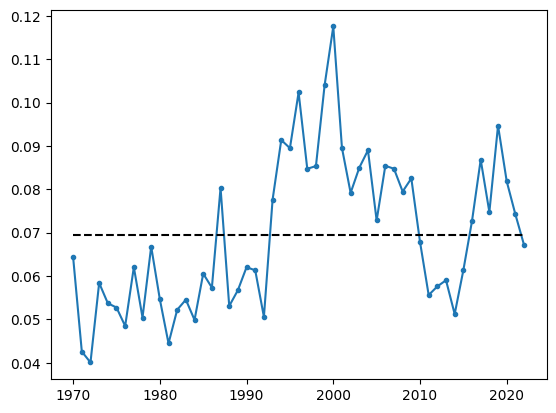

In [35]:
high_runs_by_season = df_runs.groupby('season').runs_ge10.mean()
plt.plot(high_runs_by_season, marker='.')
plt.hlines(xmin=1970, xmax=2022, y=df_runs[df_runs.season<=2017].runs_ge10.mean(), linestyle='--', color='k')

Conclusions

    - Some evidence that our model is overpredicting the probability of lower scores and underpredicting the probability of higher team scores (at least in the test set period)

    - Calibration may be able to help, but need a calibration set that reflects the distribution of the test set. (or generally the distribution of the cases you want to predict)

    - While (possibly) statistically significant, the magnitude of these difference seems minor compared to the degree of mis-calibration of the overall model

    - Overall, I suspect that the independence assumption is a bigger part of the problem than the calibration of the runs scored model

    - Next steps: further investigate approaches to calibrate and address the independence assumption